In [1]:
#Import Turing, Distributions, StatsBase, DataFrames and CSV
using Turing, Distributions, StatsBase, DataFrames, CSV, HypothesisTests, LinearAlgebra

# Import MCMCChain, Plots and StatsPlots
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(12);

# Turn off progress monitor.
Turing.turnprogress(false)

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/saumya/.julia/packages/Turing/RZOZ8/src/Turing.jl:24


false

In [2]:
# Load in the dataset downloaded from https://github.com/inertia7/timeSeries_sp500_R/blob/master/data/data_master_1.csv
#MIT License
df = CSV.read("../data/data_master_1.csv")
df[:sp_500]
# plot(df[:Date], df[Symbol("Adj Close")])

252-element CSV.Column{Float64,Float64}:
  464.5475003
  479.0725098
  493.987503 
  507.725006 
  523.650009 
  538.8050078
  553.680008 
  560.649994 
  573.7274933
  582.0299835
  594.1499938
  612.3074953
  621.354996 
    ⋮        
 2028.592499 
 2050.415039 
 2082.582459 
 2081.859925 
 2099.35492  
 2089.485046 
 2086.920044 
 2014.084992 
 1945.722504 
 1996.757538 
 2074.259979 
 2056.099976 

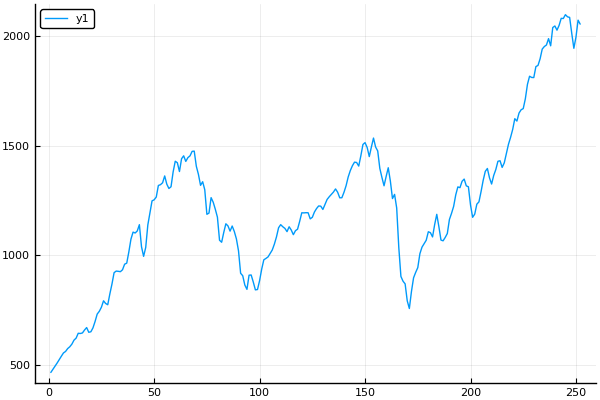

In [3]:
s = Float64[]
for ele in df[:sp_500]
# for ele in df[Symbol("Adj Close")]
    push!(s, ele)
end
pyplot()
plot(s)

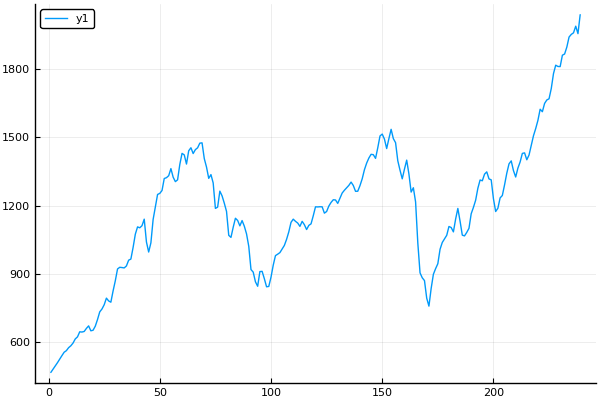

In [4]:
# Split into training and test sets. We will predict for the next 4 days using the data from the past 32 days
train_percentage = 0.95
s_train = s[1:floor(Int, train_percentage*length(s))]
N = length(s_train)

# Plot the training data
plot(s_train)

In [5]:
ADFTest(s_train, Symbol("constant"), 5)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.007150541145066936

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.7835

Details:
    sample size in regression:          233
    number of lags:                     5
    ADF statistic:                      -0.9133697735711407
    Critical values at 1%, 5%, and 10%: [-3.45801 -2.87371 -2.57326]


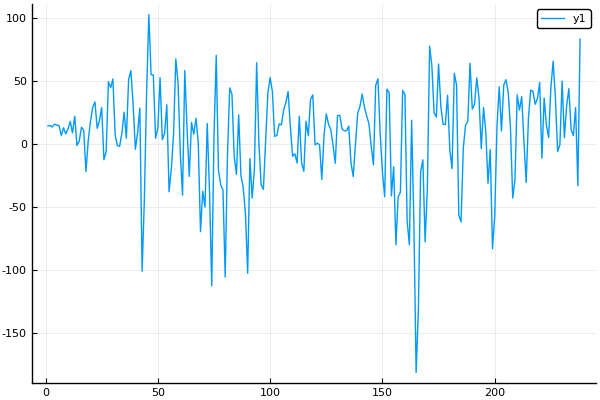

In [6]:
s_diff = diff(s_train)
N_diff = length(s_diff)
plot(s_diff)

In [7]:
ADFTest(s_diff, Symbol("constant"), 5)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.5490223385232728

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-5

Details:
    sample size in regression:          232
    number of lags:                     5
    ADF statistic:                      -5.302400338677715
    Critical values at 1%, 5%, and 10%: [-3.45813 -2.87376 -2.57328]


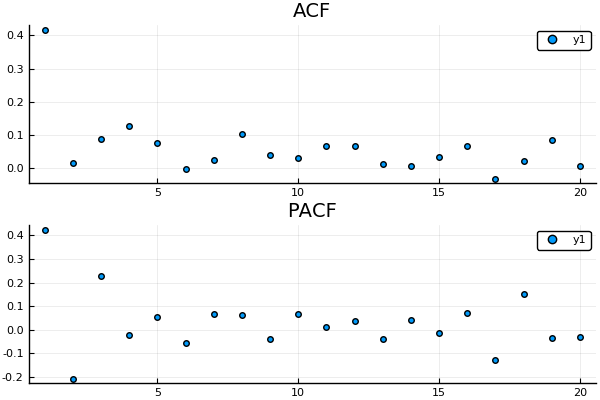

In [8]:
#Plot ACF and PACF plots
total_lags = 20
s1 = scatter(collect(1:total_lags), autocor(s_diff, collect(1:total_lags)), title = "ACF")
s2 = scatter(collect(1:total_lags), pacf(s_diff, collect(1:total_lags)), title = "PACF")
plot(s1, s2, layout = (2, 1))
# The PACF plot cuts off at k = 2, so we will have an AR(2) model for this dataset.

In [9]:
#Defining the model
σ = 1.0
@model ARIMA110(x, N) = begin
    beta_1 ~ Uniform(-1, 1)
    for t in 3:N
        val = rand(Normal(0, 1)) + beta_1 * x[t-1] 
        x[t] ~ Normal(val, 0.1) 
    end
end;

In [10]:
# Sample using HMC
chain_ARIMA110 = sample(ARIMA110(s_diff, N_diff), HMC(500, 0.05, 10) )

[HMC] Finished with
  Running time        = 5.366999246000001;
  Accept rate         = 0.002;
  #lf / sample        = 9.98;
  #evals / sample     = 0.002;
  pre-cond. metric    = [1.0].


Object of type Chains, with data of type 500×7×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = elapsed, epsilon, eval_num, lf_eps, lf_num, lp
parameters        = beta_1

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean     │ std       │ naive_se    │ mcse    │ ess     │
│     │ Symbol     │ Float64  │ Float64   │ Float64     │ Float64 │ Any     │
├─────┼────────────┼──────────┼───────────┼─────────────┼─────────┼─────────┤
│ 1   │ beta_1     │ 0.337573 │ 3.334e-16 │ 1.49101e-17 │ 0.0     │ 2.00803 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64  │
├─────┼────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 1   │ beta_1     │ 0.337573 │ 0.337573 │ 0.337573 │ 0.337573 │ 0

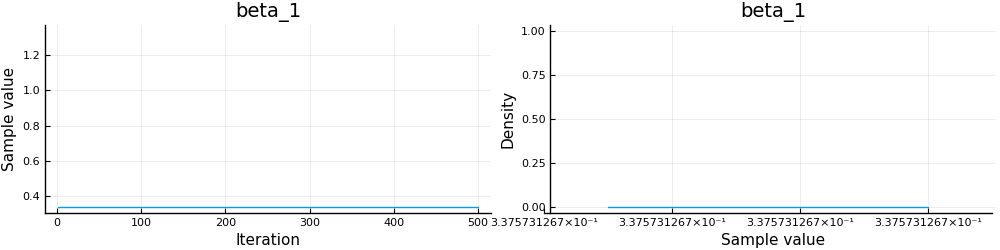

In [11]:
plot(chain_ARIMA110)

In [12]:
#Defining the model
σ = 1.0
@model ARIMA011(x, N) = begin
    beta_1 ~ Uniform(-1, 1)
    for t in 3:N
        val = rand(Normal(0,σ)) + beta_1 * rand(Normal(0, 1)) 
        x[t] ~ Normal(val, 1) 
    end
end;

# @model ARIMA011(x, N, ::Type{TV}=Vector{Float64}) where {TV}=begin
#     beta_1 ~ Uniform(-1, 1)
#     for t in 3:N
#         val = rand(Normal(0,σ)) + beta_1 * rand(Normal(0, 1)) 
#         x[t] ~ Normal(val, 1) 
#     end
# end;

In [13]:
# Sampling using HMC
chain_ARIMA011 = sample(ARIMA011(s_diff, N_diff), HMC(500, 0.05, 10))

[HMC] Finished with
  Running time        = 4.133457920999999;
  Accept rate         = 0.008;
  #lf / sample        = 9.98;
  #evals / sample     = 0.002;
  pre-cond. metric    = [1.0].


Object of type Chains, with data of type 500×7×1 Array{Union{Missing, Float64},3}

Log evidence      = 0.0
Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = elapsed, epsilon, eval_num, lf_eps, lf_num, lp
parameters        = beta_1

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean      │ std      │ naive_se  │ mcse      │ ess     │
│     │ Symbol     │ Float64   │ Float64  │ Float64   │ Float64   │ Any     │
├─────┼────────────┼───────────┼──────────┼───────────┼───────────┼─────────┤
│ 1   │ beta_1     │ -0.896623 │ 0.368712 │ 0.0164893 │ 0.0885136 │ 6.52251 │

Quantiles

│ Row │ parameters │ 2.5%      │ 25.0%     │ 50.0%     │ 75.0%     │ 97.5%    │
│     │ Symbol     │ Float64   │ Float64   │ Float64   │ Float64   │ Float64  │
├─────┼────────────┼───────────┼───────────┼───────────┼───────────┼──────────┤
│ 1   │ beta_1     │ -0.993081 │ -0.990621 │ -0.980645

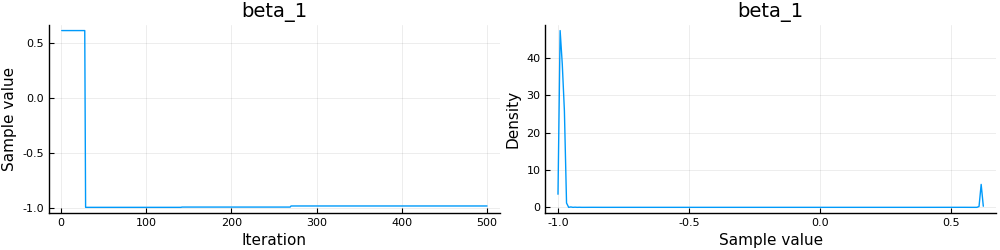

In [14]:
plot(chain_ARIMA011)

In [15]:
# ARIMA 110 AIC calculation

function calculate_aic_ARIMA110(β::Float64, σ::Float64, s::Array{Float64, 1})
    N = length(s)
    Γ = Array{Float64}(undef, (N,N))
    for i = 1:N
        pow = 1.0
        for j = i:N
            Γ[i, j] = Γ[j, i] = pow
            pow = pow*β
        end
    end
    Γ = (σ^2/(1 - β^2))*Γ
#     println(Γ[1,1])
#     likelihood = (2*π)^(-N/2)*abs(det(Γ))^(-1/2)*exp(-0.5*s'*inv(Γ)*s)
#     println(-0.5*s'*inv(Γ)*s)
#     log_likelihood = log(likelihood)
    log_likelihood = (-N/2)*log(2*π) - 0.5*abs(det(Γ)) - 0.5*(s'inv(Γ)*s)
    aic = -2*log_likelihood + 1
    return aic
end

# ARIMA 011 AIC calculation

function calculate_aic_ARIMA011(β::Float64, σ::Float64, s::Array{Float64, 1})
    N = length(s)
    Γ = Matrix{Float64}(I, N, N)
    Γ = (1 + β)*Γ
#     println(Γ)
    Γ[1, 2] = Γ[2,1] = Γ[2, 3] = Γ[3, 2] = β
    Γ = σ^2*Γ
    likelihood = (2*π)^(-N/2)*abs(det(Γ))^(-1/2)*exp(-0.5*s'*inv(Γ)*s)
    log_likelihood = log(likelihood)
    aic = -2*log_likelihood + 1
    return aic
end

calculate_aic_ARIMA011 (generic function with 1 method)

In [16]:
calculate_aic_ARIMA011(mean(chain_ARIMA011[:beta_1].value), σ, s_train)
# calculate_aic_ARIMA110(mean(chain_ARIMA110[:beta_1].value), σ, s_train)

Inf

In [17]:
Γ = Array{Float64}(undef, (3,3))
det(Γ)

NaN

In [18]:
# mean(chain_ARIMA011[:beta_1].value)
0.6^N_diff

1.5848844023188836e-53